# 採用課題　過学習抑制モデル　改善

## 準備

In [ ]:
#!pip install wandb

In [ ]:
import wandb

In [ ]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: so-hamaguchi (so-hamaguchi-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

以下で、ランダムシードの固定を行う。
シード値は４２とする。

最後のバックエンドの指示：

deterministicは計算の順番を固定化することで、計算のズレをなくすというもの。再現性を高める

benchmarkは計算アルゴリズムを固定化するもの。こちらも再現性を高める。

In [ ]:
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
# ハイパーパラメータ一覧
# この部分を変更することで、ハイパラを変更できます。

config = {
    "learning_rate": 0.001,
    "batch_size": 512,
    "epochs": 40,
    "weight_decay": 1e-4,
    "architecture": "ResNet50",
    "dataset": "CIFAR-10",
    "optimizer": "Adam",
    "augmentation": "flip, crop, rotate",
    "note": "過学習抑制実験２＿データ拡張弱め＿エポックより増"
}

In [ ]:
wandb.init(
    project="cifar10-resnet",
    name="experiment_regularization6",
    config=config
)

## 画像データ前処理

まずここで、データの拡張を行って、過学習を抑える処置を行う。
エポックごとに違う加工がなされることにより、汎化性能が上がる

valデータの方が正解率が高くなったことから、データ拡張した画像が学習するには難しすぎたということが考えられるので、データ拡張の程度を少し弱める

transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),を削除。paddingを４→２へ、Rotationを10→５へ

In [ ]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomCrop(32, padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train = True, download=True, transform = train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train = False, download=True, transform = val_transform)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = wandb.config.batch_size, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size = wandb.config.batch_size, shuffle=False, num_workers=2)

In [ ]:
data_iter = iter(train_dataloader)

In [ ]:
imgs, labels = next(data_iter)

In [ ]:
labels

tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
        2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
        2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7, 8, 7, 0, 2, 5, 2, 5, 8,
        6, 7, 4, 0, 5, 2, 0, 5, 1, 5, 5, 5, 1, 8, 6, 5, 7, 4, 9, 3, 2, 6, 6, 7,
        0, 1, 2, 3, 4, 6, 5, 9, 3, 5, 8, 8, 2, 6, 5, 0, 0, 2, 2, 0, 4, 4, 5, 2,
        8, 7, 4, 7, 2, 2, 0, 3, 9, 7, 9, 6, 6, 8, 4, 9, 4, 2, 6, 4, 3, 3, 6, 5,
        1, 1, 5, 0, 3, 0, 0, 7, 2, 3, 9, 3, 6, 8, 7, 9, 9, 1, 6, 2, 1, 4, 2, 9,
        5, 3, 0, 1, 8, 0, 7, 5, 5, 5, 7, 2, 3, 3, 5, 7, 2, 0, 3, 3, 3, 8, 5, 3,
        5, 8, 3, 7, 5, 7, 2, 3, 3, 3, 6, 1, 5, 9, 1, 6, 8, 7, 3, 0, 8, 0, 4, 8,
        1, 9, 3, 2, 8, 3, 7, 0, 8, 9, 2, 6, 8, 1, 8, 9, 2, 3, 0, 2, 1, 6, 3, 3,
        4, 4, 5, 3, 8, 9, 7, 6, 8, 6, 1, 8, 3, 9, 8, 6, 7, 8, 8, 5, 9, 2, 7, 6,
        4, 4, 0, 2, 2, 9, 2, 8, 6, 0, 5, 4, 9, 0, 8, 8, 9, 8, 5, 0, 0, 7, 3, 2,
        5, 3, 6, 6, 4, 4, 2, 5, 2, 6, 0,

In [ ]:
imgs.size()

torch.Size([512, 3, 32, 32])

In [ ]:
img = imgs[0]

In [ ]:
img_permute = img.permute(1,2,0)

In [ ]:
img_permute = 0.5*img_permute + 0.5

In [ ]:
img_permute = np.clip(img_permute,0,1)

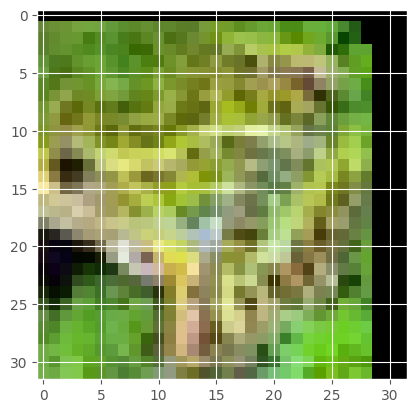

In [ ]:
plt.imshow(img_permute)

In [ ]:
model = resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

weight_decayというハイパーパラメータを追加。

これを行うことで、一点だけに重みが偏るみたいなことがないように、重みを大きくしないでほしいという抑制がかかる。

そうすると、本当に重要な部分（猫の耳とか）にのみ重みがつくようになる

過学習抑制の効果が期待できる。


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

In [ ]:
num_epochs = wandb.config.epochs

losses = []
accs = []
val_losses = []
val_accs = []

for  epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  for imgs, labels in  train_dataloader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    loss.backward()
    running_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    running_acc += torch.mean(pred.eq(labels).float())
    optimizer.step()

  running_loss /= len(train_dataloader)
  running_acc /= len(train_dataloader)
  losses.append(running_loss)
  accs.append(running_acc)
#
#validation loop
#
  model.eval()
  val_running_loss = 0.0
  val_running_acc = 0.0

  all_preds = []
  all_labels = []
  misclassified_images = []

  for val_imgs, val_labels in validation_dataloader:
    val_imgs = val_imgs.to(device)
    val_labels = val_labels.to(device)
    with torch.no_grad():
      val_output  = model(val_imgs)
      val_loss = criterion(val_output, val_labels)
    val_running_loss += val_loss.item()
    val_pred = torch.argmax(val_output, dim=1)
    val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    all_preds.extend(val_pred.cpu().numpy())
    all_labels.extend(val_labels.cpu().numpy())

    # 予測と正解が違う場所（インデックス）を探す
    mistakes = val_pred != val_labels

    # 間違えた画像のインデックスを取得
    mistake_indices = mistakes.nonzero(as_tuple=True)[0]

    # 間違えた画像をリストに追加（32枚集まったら終了）
    if len(misclassified_images) < 32:
      for idx in mistake_indices:
        if len(misclassified_images) >= 32: break

        img = val_imgs[idx].cpu()
        pred_label = names[val_pred[idx].item()]
        true_label = names[val_labels[idx].item()]

        img = img * 0.5 + 0.5

        # W&B用の画像データにしてリストに入れる
        misclassified_images.append(
        wandb.Image(img, caption=f"Pred: {pred_label}, True: {true_label}")
       )

  #precision,recall,f1の計算
  precision, recall, f1, _ = precision_recall_fscore_support(
      all_labels, all_preds, average='macro', zero_division=0
  )

  #混同行列作成
  cm = confusion_matrix(all_labels, all_preds)
  fig, ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names, yticklabels=names, ax=ax)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix (Epoch {epoch+1})')

  cm_image = wandb.Image(fig)
  plt.close(fig)

  val_running_loss /= len(validation_dataloader)
  val_running_acc /= len(validation_dataloader)
  val_losses.append(val_running_loss)
  val_accs.append(val_running_acc)
  print("epoch: {}, loss: {}, acc:{}, \
  val loss: {}, val acc: {}, F1: {}".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc, f1))

  wandb.log({
      "epoch":epoch + 1,
      "acc": running_acc,
      "loss": running_loss,
      "val acc": val_running_acc,
      "val loss": val_running_loss,
      "val precision": precision,
      "val recall": recall,
      "val f1": f1,
      "confusion_matrix": cm_image,
      "Misclassified Examples": misclassified_images
      })

torch.save(model.state_dict(), "baseline_model.pth")
wandb.save("baseline_model.pth")

epoch: 1, loss: 1.956289843637116, acc:0.3085159361362457,   val loss: 1.5860184609889985, val acc: 0.4239889681339264, F1: 0.4140910844567923
epoch: 2, loss: 1.8695142463761933, acc:0.3091982901096344,   val loss: 1.5782416760921478, val acc: 0.3981158137321472, F1: 0.3800966368106661
epoch: 3, loss: 1.5642804990009385, acc:0.42289331555366516,   val loss: 1.420669573545456, val acc: 0.4703125059604645, F1: 0.45726267453391084
epoch: 4, loss: 1.4370885990103897, acc:0.4754891097545624,   val loss: 1.3442029297351836, val acc: 0.5057387351989746, F1: 0.49925602866400975
epoch: 5, loss: 1.3520551323890686, acc:0.5048163533210754,   val loss: 1.2544467628002167, val acc: 0.5462316274642944, F1: 0.5394538453026771
epoch: 6, loss: 1.2772832792632434, acc:0.537917971611023,   val loss: 1.2124435186386109, val acc: 0.5535902976989746, F1: 0.5331580951476179
epoch: 7, loss: 1.2148430006844657, acc:0.5602384209632874,   val loss: 1.1170979499816895, val acc: 0.599528968334198, F1: 0.5995242950

['/content/wandb/run-20251124_082045-uotgbsxb/files/baseline_model.pth']

##評価

評価指標について

ROC-AUCは多クラス分類において説明が煩雑になるため、今回は見送り。

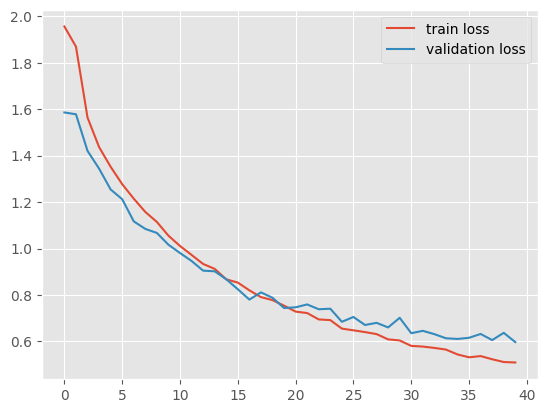

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

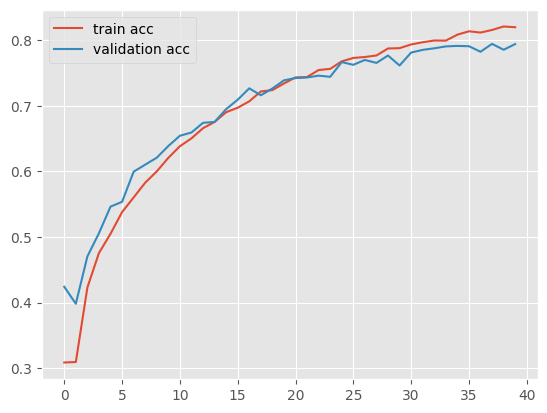

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend()

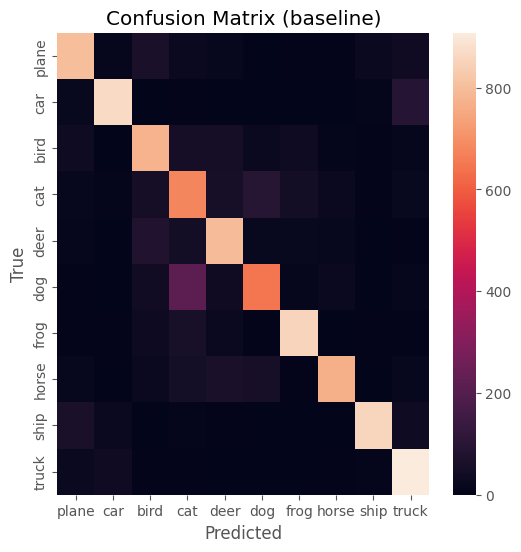

In [ ]:


# 1. 全予測を集める
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in validation_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 2. 混同行列
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    xticklabels=names,
    yticklabels=names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (baseline)")
plt.show()


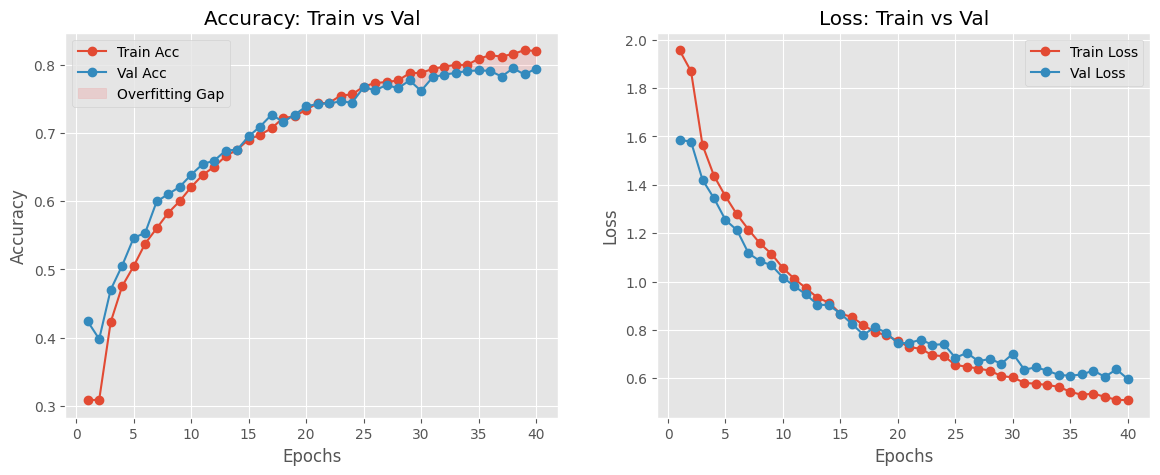

In [ ]:
# データをCPUに移してリスト化（念のため）
train_acc_list = [x.item() if isinstance(x, torch.Tensor) else x for x in accs]
val_acc_list = [x.item() if isinstance(x, torch.Tensor) else x for x in val_accs]
train_loss_list = [x if isinstance(x, float) else x.item() for x in losses]
val_loss_list = [x if isinstance(x, float) else x.item() for x in val_losses]

epochs_range = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(14, 5))

# --- 精度 (Accuracy) の比較グラフ ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label='Train Acc', marker='o')
plt.plot(epochs_range, val_acc_list, label='Val Acc', marker='o')

# ★ここがポイント：ギャップを塗りつぶす
plt.fill_between(epochs_range, train_acc_list, val_acc_list, where=[t > v for t, v in zip(train_acc_list, val_acc_list)],
                 color='red', alpha=0.1, label='Overfitting Gap')

plt.title('Accuracy: Train vs Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# --- 損失 (Loss) の比較グラフ ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss_list, label='Val Loss', marker='o')
plt.title('Loss: Train vs Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
wandb.finish()

acc,▁▁▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇█▇██████████
val f1,▂▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████████
val loss,██▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val precision,▁▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇██████████
val recall,▁▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇█▇██████████
acc,0.81993
epoch,40
loss,0.50943
